# Training a VAE on MNIST

This notebook was originally written by Stéphane Lathuillière: <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://stelat.eu/

First, you'll need to enable and test the GPU for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


## Data loading
Let's import some libraries and load the MNIST dataset.

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import IPython.display
import numpy as np

bs = 100

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.9MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.29MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## Architecture specification

You can use the following encoder (don't forget that in a VAE the decoder has two heads, for the mean and the variance):
```
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
```
and this decoder:
```
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
```
Then, you need to complete the forward function. You can use Relu activations for every layer except for the heads that can reach negative values. Concerning the decoder head, you can use sigmoid to obtain values in [0,1].

Here we consider a latent space of dimension 2 but is could be any *zdim* dimension.

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)


    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h1 = self.fc31(h)
        h2 = self.fc32(h)
        return h1, h2

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)    # ...
        return mu + std*eps            # ... return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))       # ...
        h = F.relu(self.fc5(h))       # ...
        return F.sigmoid(self.fc6(h)) # ...

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1,784))# ...
        z = self.sampling(mu, log_var) # ...
        x_rec = self.decoder(z) # ...
        return x_rec, mu, log_var


## Loss function
The total loss of the VAE is composed of two terms: a reconstruction term and the KL divergence with the Prior.

Assuming a standard prior $\mathcal{N}(0,Id)$ for $p(z)$ and a Gaussian $\mathcal{N}(\mu, \mathsf{diag}(\sigma))$ for $q(z|x)$, we recall that
$$ KL( q(z|x) \parallel p(z) ) = \frac{1}{2} \left[ - \sum_i (1 + \log \sigma_i^2) + \sum_i \sigma_i^2 + \sum_i \mu_i^2 \right] .$$

In [4]:
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()
optimizer = optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(x_rec , x, mu, log_var):
    RecLoss = F.mse_loss(x_rec, x.view(-1,784), reduction = 'sum')  # ...
    KLDLoss = 0.5 * torch.sum(-log_var - 1 + log_var.exp() * mu**2) # ...
    return RecLoss + KLDLoss


## Training step
In this cell, we define the function that performs training on one epoch. We recommend to debug it using the "main loop" cell later in the page.

In [5]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        rec_data, mu, log_var = vae.forward(data)          # ...
        loss = loss_function(rec_data , data, mu, log_var) # ...
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

## Visualization:
We provide some visualization functions:

In [15]:

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(10, 10), figsize=(10, 10)):
    generatedImages=generatedImages.cpu().numpy()
    print(generatedImages.shape)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    IPython.display.display(IPython.display.Image(data=('gan_generated_image_epoch_%d.png' % epoch)))


## Test
Complete the test function that generate new sample from latent space samples.

In [12]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae.forward(data) # ...

            # sum up batch loss
            test_loss += loss_function(recon , data, mu, log_var) # ...

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    with torch.no_grad():
      z = torch.randn(64, 2).cuda()
      generated = vae.decoder(z) # ...
      plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28))
      #save_image(sample.view(64, 1, 28, 28), '.sample_' + '.png')



## Main loop

Train Epoch: 1 [0/60000 (0%)]	Loss: 36.346841
Train Epoch: 1 [10000/60000 (17%)]	Loss: 35.829687
Train Epoch: 1 [20000/60000 (33%)]	Loss: 35.105527
Train Epoch: 1 [30000/60000 (50%)]	Loss: 39.666389
Train Epoch: 1 [40000/60000 (67%)]	Loss: 36.949907
Train Epoch: 1 [50000/60000 (83%)]	Loss: 36.400251
====> Epoch: 1 Average loss: 37.0126
Train Epoch: 2 [0/60000 (0%)]	Loss: 36.202290
Train Epoch: 2 [10000/60000 (17%)]	Loss: 35.245405
Train Epoch: 2 [20000/60000 (33%)]	Loss: 34.410786
Train Epoch: 2 [30000/60000 (50%)]	Loss: 38.655249
Train Epoch: 2 [40000/60000 (67%)]	Loss: 35.976484
Train Epoch: 2 [50000/60000 (83%)]	Loss: 37.444795
====> Epoch: 2 Average loss: 36.1722
Train Epoch: 3 [0/60000 (0%)]	Loss: 35.730164
Train Epoch: 3 [10000/60000 (17%)]	Loss: 36.013821
Train Epoch: 3 [20000/60000 (33%)]	Loss: 33.459524
Train Epoch: 3 [30000/60000 (50%)]	Loss: 39.765544
Train Epoch: 3 [40000/60000 (67%)]	Loss: 35.523506
Train Epoch: 3 [50000/60000 (83%)]	Loss: 37.418662
====> Epoch: 3 Average 

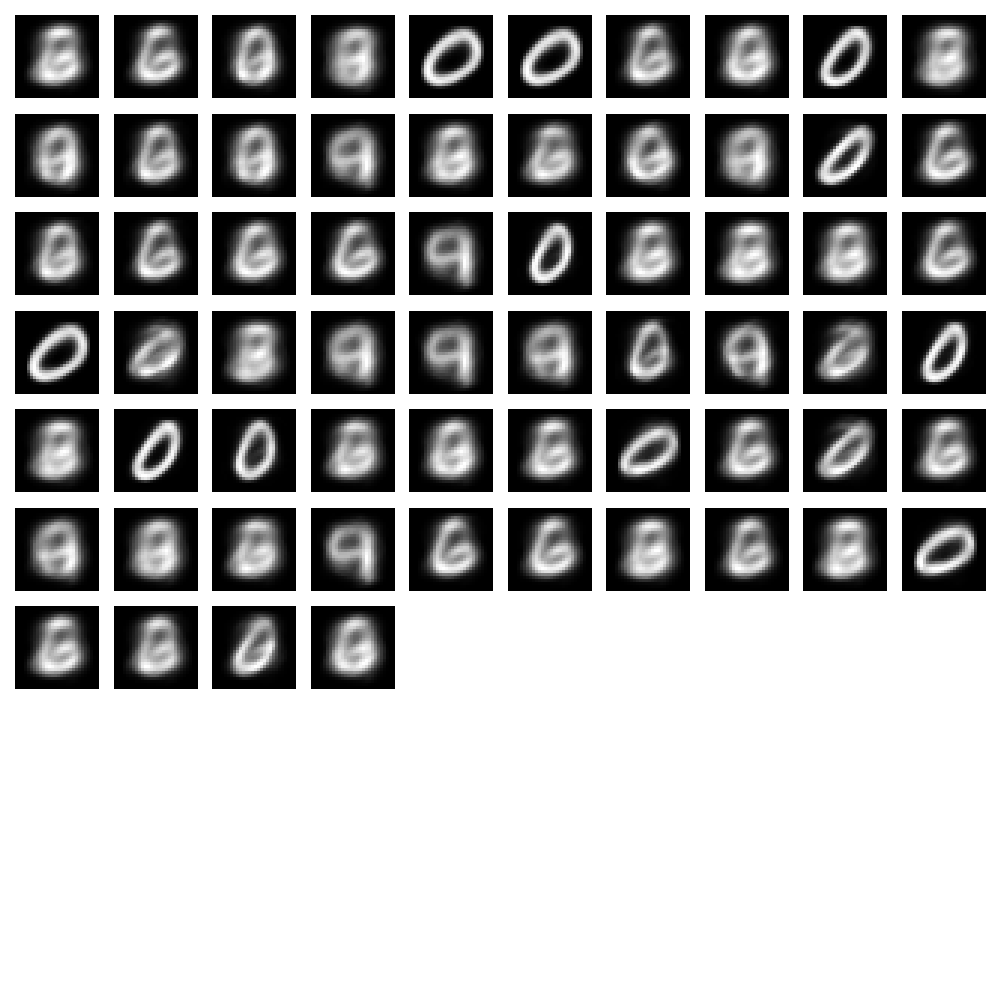

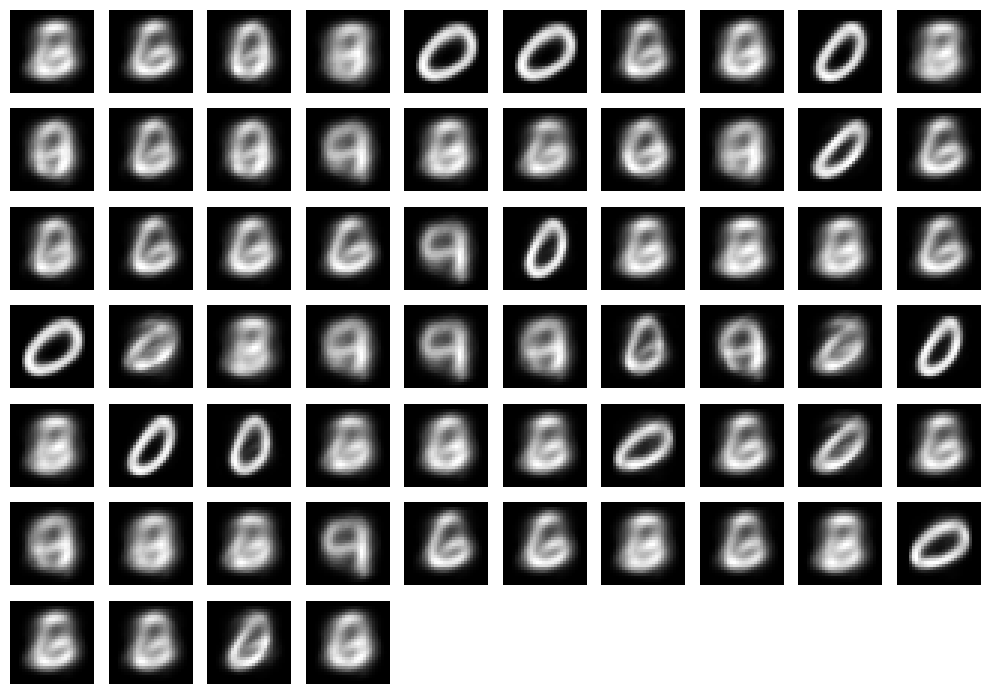

In [14]:

for epoch in range(1, 5):
    train(epoch)
test()


## Bonus 1: Interpolation
Sample two latent vectors z1 and z2 and generate the corresponding images. Then, generate 10 intermediate images by performing linear interpolation in the latent space between the z1 and z2.

In [ ]:
# ...

## Bonus 2: Visualization
Generate a 10x10 mosaic by sampling *z* over a regulargrid in [-1,1]x[-1,1]. What do you observe?


In [ ]:
# ...